# Average Ensemble Model

## 1. Imports

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import tensorflow as tf
import urllib.request as request

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

2024-07-10 21:25:12.929658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 21:25:12.929806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 21:25:13.072266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load model

### a. Mobilenet

In [2]:
mobilenet_base = tf.keras.applications.MobileNet(
                input_shape=(224,224,3),
                weights="imagenet",
                include_top=False
            )

for _ in mobilenet_base.layers:
  mobilenet_base.trainable = False

global_avg_in = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_base.output)
prediction = tf.keras.layers.Dense(units=30, activation="softmax")(global_avg_in)
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=prediction, name='model_mobilenet')

mobilenet_model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "model_mobilenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,259,614 (12.43 MB)

 Trainable params: 30,750 (120.12 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

### b. MobilnetV2

In [3]:
mobilenetv2_base = tf.keras.applications.MobileNetV2(
                input_shape=(224,224,3),
                weights="imagenet",
                include_top=False
            )

for _ in mobilenetv2_base.layers:
  mobilenetv2_base.trainable = False

global_avg_in = tf.keras.layers.GlobalAveragePooling2D()(mobilenetv2_base.output)
prediction = tf.keras.layers.Dense(units=30, activation="softmax")(global_avg_in)
mobilenetv2_model = Model(inputs=mobilenetv2_base.input, outputs=prediction, name='model_mobilenetv2')

mobilenetv2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "model_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### c. Densenet201

In [4]:
densenet201_base = tf.keras.applications.DenseNet201(
                input_shape=(224,224,3),
                weights="imagenet",
                include_top=False
            )

for _ in densenet201_base.layers:
  densenet201_base.trainable = False

global_avg_in = tf.keras.layers.GlobalAveragePooling2D()(densenet201_base.output)
prediction = tf.keras.layers.Dense(units=30, activation="softmax")(global_avg_in)
densenet201_model = Model(inputs=densenet201_base.input, outputs=prediction, name='model_densenet201')

densenet201_model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "model_densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,379,614 (70.11 MB)

 Trainable params: 57,630 (225.12 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

## 3. Building an ensemble model

In [5]:
def ensemble_average(models, model_input):
    outputs = [model(model_input) for model in models]
    y = Average()(outputs)
    model = Model(inputs=model_input, outputs=y, name='ensemble')
    return model

In [6]:
model_input = Input(shape=(224, 224, 3))

### a. First ensemble model
This model is combination of `mobilenet` and `mobilenetv2`

In [7]:
ensemble_model_1 = ensemble_average(models = [mobilenet_model, mobilenetv2_model], model_input = model_input)

In [8]:
ensemble_model_1.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenet     │ (None, 30)        │  3,259,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenetv2   │ (None, 30)        │  2,296,414 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 30)        │          0 │ model_mobilenet[… │
│                     │                   │            │ model_mobilenetv… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,556,028 (21.19 MB)

 Trainable params: 69,180 (270.23 KB)

 Non-trainable params: 5,486,848 (20.93 MB)

In [9]:
ensemble_model_1.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top1_accuracy", k=1),
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top5_accuracy"),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(
                               name="auc", multi_label=True, num_labels=30, from_logits=False, label_weights=None),

                       ]
                       )

### b. Second ensemble model
This model is combination of `mobilenet` and `densenet201`.

In [10]:
ensemble_model_2 = ensemble_average(models = [mobilenet_model, densenet201_model], model_input = model_input)

In [11]:
ensemble_model_2.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenet     │ (None, 30)        │  3,259,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_densenet201   │ (None, 30)        │ 18,379,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, 30)        │          0 │ model_mobilenet[… │
│                     │                   │            │ model_densenet20… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,639,228 (82.55 MB)

 Trainable params: 88,380 (345.23 KB)

 Non-trainable params: 21,550,848 (82.21 MB)

In [12]:
ensemble_model_2.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top1_accuracy", k=1),
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top5_accuracy"),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(
                               name="auc", multi_label=True, num_labels=30, from_logits=False, label_weights=None),

                       ]
                       )

### c. Third ensemble model
This model is combination of `mobilenetv2` and `densenet201`

In [13]:
ensemble_model_3 = ensemble_average(models = [mobilenetv2_model, densenet201_model], model_input = model_input)

In [14]:
ensemble_model_3.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenetv2   │ (None, 30)        │  2,296,414 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_densenet201   │ (None, 30)        │ 18,379,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_2 (Average) │ (None, 30)        │          0 │ model_mobilenetv… │
│                     │                   │            │ model_densenet20… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,676,028 (78.87 MB)

 Trainable params: 96,060 (375.23 KB)

 Non-trainable params: 20,579,968 (78.51 MB)

In [15]:
ensemble_model_3.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top1_accuracy", k=1),
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top5_accuracy"),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(
                               name="auc", multi_label=True, num_labels=30, from_logits=False, label_weights=None),

                       ]
                       )

### d. Fourth ensemble model
This model is combination of `mobilenet`, `mobilenetv2` and `densenet201`

In [16]:
ensemble_model_4 = ensemble_average(models = [mobilenet_model, mobilenetv2_model, densenet201_model], model_input = model_input)

In [17]:
ensemble_model_4.summary()

Model: "ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenet     │ (None, 30)        │  3,259,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_mobilenetv2   │ (None, 30)        │  2,296,414 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_densenet201   │ (None, 30)        │ 18,379,614 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_3 (Average) │ (None, 30)        │          0 │ model_mobilenet[… │
│                     │                   │            │ model_mobilenetv… │
│                     │                   │            │ model_densenet20… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,935,642 (91.31 MB)

 Trainable params: 126,810 (495.35 KB)

 Non-trainable params: 23,808,832 (90.82 MB)

In [18]:
ensemble_model_4.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top1_accuracy", k=1),
                           tf.keras.metrics.TopKCategoricalAccuracy(
                               name="top5_accuracy"),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(
                               name="auc", multi_label=True, num_labels=30, from_logits=False, label_weights=None),

                       ]
                       )

## 4. Data Preparation

In [19]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS= 35

In [20]:
datagenerator_kwargs = dict(
    rescale=1./255,
)
dataflow_kwargs = dict(
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

In [21]:
training_data_path = os.path.join("/kaggle/input/medicinal-plants-leaf-images", "dataset_v2", "train")
validation_data_path = os.path.join("/kaggle/input/medicinal-plants-leaf-images", "dataset_v2", "val")

In [22]:
valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagenerator_kwargs
)

train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    **datagenerator_kwargs
)

train_generator = train_datagenerator.flow_from_directory(
    directory=training_data_path,
    shuffle=True,
    **dataflow_kwargs
)
valid_generator = valid_datagenerator.flow_from_directory(
    directory=validation_data_path,
    shuffle=False,
    **dataflow_kwargs
)

Found 4116 images belonging to 30 classes.
Found 509 images belonging to 30 classes.


In [23]:
def exp_decay(epoch):
    decay_rate = LEARNING_RATE / EPOCHS
    lrate = LEARNING_RATE * np.exp(-decay_rate*epoch)
    return lrate

In [24]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                min_delta=0.00001,
                                                patience=20,
                                                mode="auto",
                                                restore_best_weights=False),
             tf.keras.callbacks.LearningRateScheduler(exp_decay)
             ]

## 5. Training

In [25]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

history = ensemble_model_4.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/128 ━━━━━━━━━━━━━━━━━━━━ 2:32:21 72s/step - auc: 0.4688 - loss: 3.4118 - precision: 0.0000e+00 - recall: 0.0000e+00 - top1_accuracy: 0.1250 - top5_accuracy: 0.2500

I0000 00:00:1720646860.379866     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720646860.520521     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/128 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - auc: 0.8516 - loss: 2.3253 - precision: 0.7187 - recall: 0.0411 - top1_accuracy: 0.4315 - top5_accuracy: 0.7029 - val_auc: 0.9627 - val_loss: 0.8339 - val_precision: 0.9915 - val_recall: 0.4875 - val_top1_accuracy: 0.8729 - val_top5_accuracy: 0.9854 - learning_rate: 0.0010
Epoch 2/35
  1/128 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - auc: 0.7328 - loss: 0.8014 - precision: 1.0000 - recall: 0.5625 - top1_accuracy: 0.9062 - top5_accuracy: 1.0000

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - auc: 0.7328 - loss: 0.8014 - precision: 1.0000 - recall: 0.5625 - top1_accuracy: 0.9062 - top5_accuracy: 1.0000 - val_auc: 0.0667 - val_loss: 1.0184 - val_precision: 1.0000 - val_recall: 0.3448 - val_top1_accuracy: 0.7241 - val_top5_accuracy: 0.9655 - learning_rate: 9.9997e-04
Epoch 3/35
128/128 ━━━━━━━━━━━━━━━━━━━━ 78s 579ms/step - auc: 0.9912 - loss: 0.8341 - precision: 0.9857 - recall: 0.5018 - top1_accuracy: 0.8664 - top5_accuracy: 0.9946 - val_auc: 0.9646 - val_loss: 0.5383 - val_precision: 0.9783 - val_recall: 0.7500 - val_top1_accuracy: 0.9208 - val_top5_accuracy: 0.9958 - learning_rate: 9.9994e-04
Epoch 4/35
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7317 - loss: 0.5185 - precision: 0.9583 - recall: 0.7188 - top1_accuracy: 0.8125 - top5_accuracy: 1.0000 - val_auc: 0.0667 - val_loss: 0.5909 - val_precision: 1.0000 - val_recall: 0.6552 - val_top1_accuracy: 0.8276 - val_top5_accuracy: 1.0000 - learning_rate: 9.9991e-04
Epoch 5/3

## 6. Training Metrics

In [26]:
def plot_training_history(history, title, plot_path, graph_title):
    plt.clf()
    plt.plot(history.history[title])
    plt.plot(history.history["val_" + title])
    plt.title(
      graph_title+" "+"("+ "Avg. Ensemble" +")")
    plt.xlabel("epochs")
    plt.ylabel(title)
    plt.legend([title, "val_" + title])
    plt.savefig(plot_path)

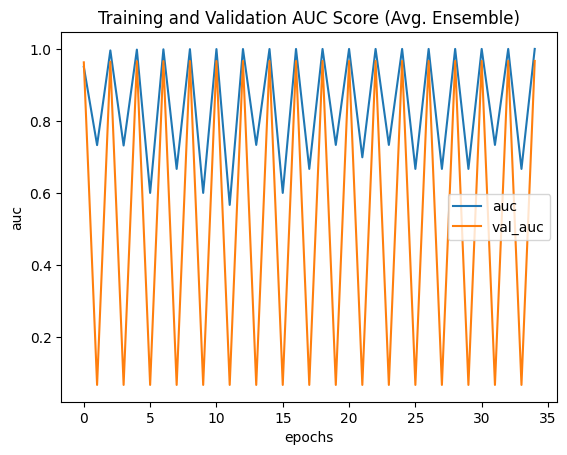

In [27]:
plot_training_history(history, "top1_accuracy", "./avgensemble_ensemble_model_4_top1accuracy.png", "Training and Validation Top-1 Accuracy")
plot_training_history(history, "top5_accuracy", "./avgensemble_ensemble_model_4_top5accuracy.png" , "Training and Validation Top-5 Accuracy")
plot_training_history(history, "loss", "./avgensemble_ensemble_model_4_loss.png", "Training and Validation Loss")
plot_training_history(history, "precision", "./avgensemble_ensemble_model_4_precision.png", "Training and Validation Precision")
plot_training_history(history, "recall", "./avgensemble_ensemble_model_4_recall.png", "Training and Validation Recall")
plot_training_history(history, "auc", "./avgensemble_ensemble_model_4_auc.png", "Training and Validation AUC Score")

In [28]:
ensemble_model_4.save("./avgensemble_ensemble_model_4.keras")

In [29]:
scores = {"loss": history.history['loss'][EPOCHS-1],
                  "top1_accuracy": history.history['top1_accuracy'][EPOCHS-1],
                  "top5_accuracy": history.history['top5_accuracy'][EPOCHS-1],
                  "precision": history.history['precision'][EPOCHS-1],
                  "recall": history.history['recall'][EPOCHS-1],
                  "auc": history.history['auc'][EPOCHS-1]}

In [30]:
import json
path = "./avgensemble_ensemble_model_4_training_scores.json"
with open(path, "w") as f:
    json.dump(scores, f, indent=4)

## 7. Testing

In [31]:
datagenerator_kwargs = dict(
    rescale=1./255,
)
dataflow_kwargs = dict(
    target_size=(224,224),
    batch_size=BATCH_SIZE,
)
test_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagenerator_kwargs
)
test_data_path = os.path.join("/kaggle/input/medicinal-plants-leaf-images", "dataset_v2", "test")

test_generator = test_datagenerator.flow_from_directory(
    directory=test_data_path,
    shuffle=False,
    **dataflow_kwargs
)

Found 539 images belonging to 30 classes.


In [32]:
score = ensemble_model_4.evaluate(test_generator)
predictions = ensemble_model_4.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = test_generator.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - auc: 0.5722 - loss: 0.0874 - precision: 1.0000 - recall: 0.9849 - top1_accuracy: 0.9949 - top5_accuracy: 0.9982 
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step 


**Draw Confusion Matrix**

In [33]:
target_names = [
  "Alpinia Galanga",
  "Amaranthus Viridis",
  "Artocarpus Heterophyllus",
  "Azadirachta Indica",
  "Basella Alba",
  "Brassica Juncea",
  "Carissa Carandas",
  "Citrus Limon",
  "Ficus Auriculata",
  "Ficus Religiosa",
  "Hibiscus Rosa-sinensis",
  "Jasminum",
  "Mangifera Indica",
  "Mentha",
  "Moringa Oleifera",
  "Muntingia Calabura",
  "Murraya Koenigii",
  "Nerium Oleander",
  "Nyctanthes Arbor-tristis",
  "Ocimum Tenuiflorum",
  "Piper Betle",
  "Plectranthus Amboinicus",
  "Pongamia Pinnata",
  "Psidium Guajava",
  "Punica Granatum",
  "Santalum Album",
  "Syzygium Cumini",
  "Syzygium Jambos",
  "Tabernaemontana Divaricata",
  "Trigonella Foenum-graecum"
]
def plot_confusion_matrix(confusion_matrix):
    plt.clf()
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=target_names, yticklabels=target_names, cbar=False)
    plt.title(
      f'Confusion Matrix (Average Ensemble Model)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("./avgensemble_ensemble_model_4_cm.png")


<Figure size 640x480 with 0 Axes>

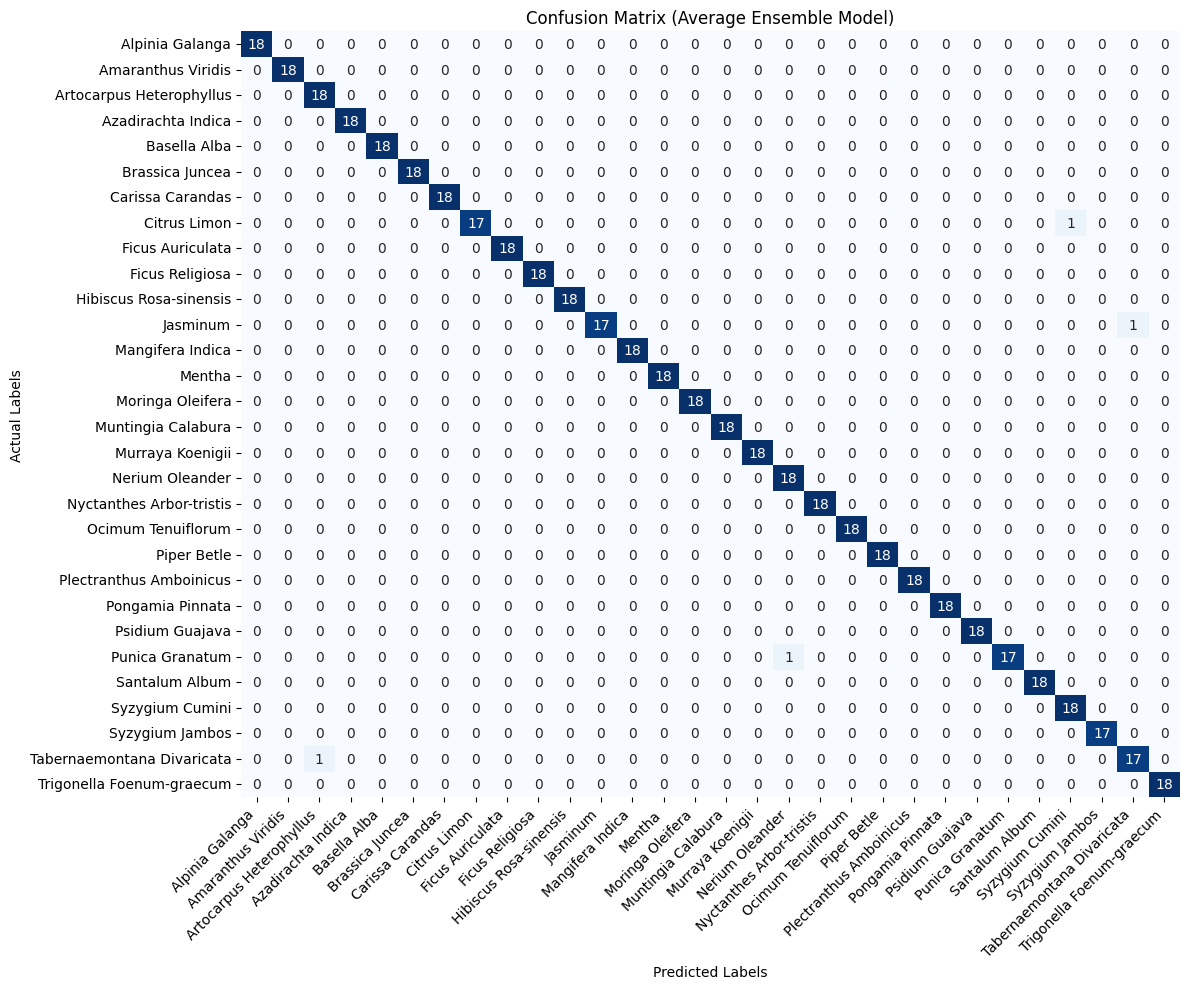

In [34]:
confusion_mtx = confusion_matrix(actual_labels, predicted_labels)
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix(confusion_mtx)

In [35]:
scores = {"loss": score[0], "top1_accuracy": score[1], "top5_accuracy": score[2],
                  "precision": score[3], "recall": score[4],
                  "auc": score[5]}

path = "./avgensemble_ensemble_model_4_testing_scores.json"
with open(path, "w") as f:
    json.dump(scores, f, indent=4)

In [36]:
report = classification_report(actual_labels, predicted_labels, target_names=target_names, output_dict=True)

In [37]:
path = "./avgensemble_ensemble_model_4_report.json"
with open(path, "w") as f:
    json.dump(report, f, indent=4)